In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid', 'navy', 'brown'])

# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 12, 6
mpl.rcParams['figure.dpi'] = 200

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

In [5]:
path = '/Users/noah/Physics/Fermilab/Interference/EW_scattering/flux_folding/'
QE_files = [path+'MB_C12_QMC_fluxfold_1b_02_03.out',path+'MB_C12_QMC_fluxfold_1b_05_06.out',path+'MB_C12_QMC_fluxfold_1b_08_09.out']

intf_files = [path+'MB_C12_QMC_fluxfold_2b_02_03.out',path+'MB_C12_QMC_fluxfold_2b_05_06.out',path+'MB_C12_QMC_fluxfold_2b_08_09.out']

QE_files_lattice = [path+'MB_C12_QMC_fluxfold_1b_02_03_lattice.out',path+'MB_C12_QMC_fluxfold_1b_05_06_lattice.out',path+'MB_C12_QMC_fluxfold_1b_08_09_lattice.out']

intf_files_lattice = [path+'MB_C12_QMC_fluxfold_2b_02_03_lattice.out',path+'MB_C12_QMC_fluxfold_2b_05_06_lattice.out',path+'MB_C12_QMC_fluxfold_2b_08_09_lattice.out']

MEC_files = [path+f'xsec_MB_0p25_2b_mec.out',path+'xsec_MB_0p55_2b_mec.out',path+'xsec_MB_0p85_2b_mec.out']

data_files = [path+f'MB_data/exp_nu_MB_0{i*10 + 5}.dat' for i in range(9,0,-1)]

bkgd_files = ['/Users/noah/Physics/Fermilab/Fortran_Wrapper/Noemi-neutrino-QEL/Flux/MB/exp_nu_MB_025_bkgd.dat','/Users/noah/Physics/Fermilab/Fortran_Wrapper/Noemi-neutrino-QEL/Flux/MB/exp_nu_MB_055_bkgd.dat','/Users/noah/Physics/Fermilab/Fortran_Wrapper/Noemi-neutrino-QEL/Flux/MB/exp_nu_MB_085_bkgd.dat' ]

QE_df = [pd.read_csv(pred,sep="\s+|\t+|\s+\t+|\t+\s+", engine='python') for pred in QE_files ]
for pred in QE_df:
    pred.columns = ['tmu', '1b','2b']
    pred['tmu'] = pred['tmu']
    pred['1b'] = (1.0e+41)*pred['1b']/1.0e+26
    pred['2b'] = (1.0e+41)*pred['2b']/1.0e+26
    
#I have to smooth out some of the QE predictions because the flux folding gave me a very noisy prediction for some reason
maxbin = [100,145,220]
fracparam = [.08,.08,.08]
tmu_interp= [0,0,0]
QE_interp = [0,0,0]

for i,df in enumerate(QE_df):
    interp = sm.nonparametric.lowess(df['1b'][:maxbin[i]], df['tmu'][:maxbin[i]],frac = fracparam[i])
    tmu_interp[i] = interp[:,0][:maxbin[i]]
    QE_interp[i] = interp[:,1][:maxbin[i]]
    
QE_lattice_df = [pd.read_csv(pred,sep="\s+|\t+|\s+\t+|\t+\s+", engine='python') for pred in QE_files_lattice ]
for pred in QE_lattice_df:
    pred.columns = ['tmu', '1b','2b']
    pred['tmu'] = pred['tmu']
    pred['1b'] = (1.0e+41)*pred['1b']/1.0e+26
    pred['2b'] = (1.0e+41)*pred['2b']/1.0e+26
    
#I have to smooth out some of the QE predictions because the flux folding gave me a very noisy prediction for some reason
maxbin_lattice = [100,145,220]
fracparam_lattice = [.08,.08,.08]
tmu_interp_lattice= [0,0,0]
QE_interp_lattice = [0,0,0]

for i,df in enumerate(QE_lattice_df):
    interp = sm.nonparametric.lowess(df['1b'][:maxbin[i]], df['tmu'][:maxbin[i]],frac = fracparam[i])
    tmu_interp_lattice[i] = interp[:,0][:maxbin[i]]
    QE_interp_lattice[i] = interp[:,1][:maxbin[i]]

intf_df = [pd.read_csv(pred,sep="\s+|\t+|\s+\t+|\t+\s+", engine='python') for pred in intf_files ]
for pred in intf_df:
    pred.columns = ['tmu', '1b','2b']
    pred['tmu'] = pred['tmu']
    pred['1b'] = (1.0e+41)*pred['1b']/1.0e+26
    pred['2b'] = (1.0e+41)*pred['2b']/1.0e+26
    
intf_lattice_df = [pd.read_csv(pred,sep="\s+|\t+|\s+\t+|\t+\s+", engine='python') for pred in intf_files_lattice ]
for pred in intf_lattice_df:
    pred.columns = ['tmu', '1b','2b']
    pred['tmu'] = pred['tmu']
    pred['1b'] = (1.0e+41)*pred['1b']/1.0e+26
    pred['2b'] = (1.0e+41)*pred['2b']/1.0e+26

intf_maxbin = [25,40,90]
intf_fracparam = [.20,.12,.09]
intf_tmu_interp= [0,0,0]
intf_interp_a = [0,0,0]

intf_lattice_maxbin = [25,40,90]
intf_lattice_fracparam = [.20,.12,.09]
intf_tmu_lattice_interp= [0,0,0]

intf_lattice_interp_a = [0,0,0]

for i,df in enumerate(intf_lattice_df):
    interp = sm.nonparametric.lowess(df['2b'][:intf_lattice_maxbin[i]], df['tmu'][:intf_lattice_maxbin[i]],frac = intf_lattice_fracparam[i])
    intf_tmu_lattice_interp[i] = interp[:,0][:intf_lattice_maxbin[i]]
    intf_lattice_interp_a[i] = interp[:,1][:intf_lattice_maxbin[i]]

for i,df in enumerate(intf_df):
    interp = sm.nonparametric.lowess(df['2b'][:intf_maxbin[i]], df['tmu'][:intf_maxbin[i]],frac = intf_fracparam[i])
    intf_tmu_interp[i] = interp[:,0][:intf_maxbin[i]]
    intf_interp_a[i] = interp[:,1][:intf_maxbin[i]]
        
    
MEC_df = [pd.read_csv(MEC_files[i],sep="\s+|\t+|\s+\t+|\t+\s+",header=None, engine='python') for i in range(0,3)]
for i in range(0,3):
    MEC_df[i].columns = ['tmu','xsec','xsec_err']
    MEC_df[i]['xsec'] =  1.0e+41*MEC_df[i]['xsec']/1.0e+26
    MEC_df[i]['xsec_err'] =  1.0e+41*MEC_df[i]['xsec_err']/1.0e+26
    MEC_df[i].dropna()  

data_df = [pd.read_csv(data_files[i],sep="\s+|\t+|\s+\t+|\t+\s+",header=None, engine='python') for i in range(0,9)]
for i in range(0,9):
    data_df[i].columns = ['tmu','xsec','xsec_err']
    data_df[i]['xsec'] = 1.0e+41*data_df[i]['xsec']
    data_df[i]['xsec_err'] = 1.0e+41*data_df[i]['xsec_err']
    
bkgd_df = [pd.read_csv(bkgd_files[i],sep="\s+|\t+|\s+\t+|\t+\s+",header=None, engine='python') for i in range(0,3)]
for df in bkgd_df:
    df.columns = ['tmu', 'xsec']
    df['xsec'] = df['xsec']*1.0e+41 / 1.0e+3
    
MEC_interp = [0,0,0]
Intf_interp = [0,0,0]
#Now interpolate all the MEC and interf responses so that we can get everything on the same x axis bins
for i in range(0,3):
    MEC_interp[i] = np.interp(tmu_interp[i], MEC_df[i]['tmu'], MEC_df[i]['xsec'])
    Intf_interp[i] = np.interp(tmu_interp[i], intf_tmu_interp[i], intf_interp_a[i])
    
Intf_interp_lattice = [0,0,0]
for i in range(0,3):
    Intf_interp_lattice[i] = np.interp(tmu_interp[i], intf_tmu_lattice_interp[i], intf_lattice_interp_a[i])

<ipython-input-3-399e42596fe5>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax4[2].errorbar(data_df[1]['tmu'],data_df[1]['xsec'],data_df[1]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB')
<ipython-input-3-399e42596fe5>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax4[1].errorbar(data_df[4]['tmu'],data_df[4]['xsec'],data_df[4]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB')
<ipython-input-3-399e42596fe5>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax4[0].errorbar(data_df[7]['tmu'],data_df[7]['xsec'],data_df[7]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB')


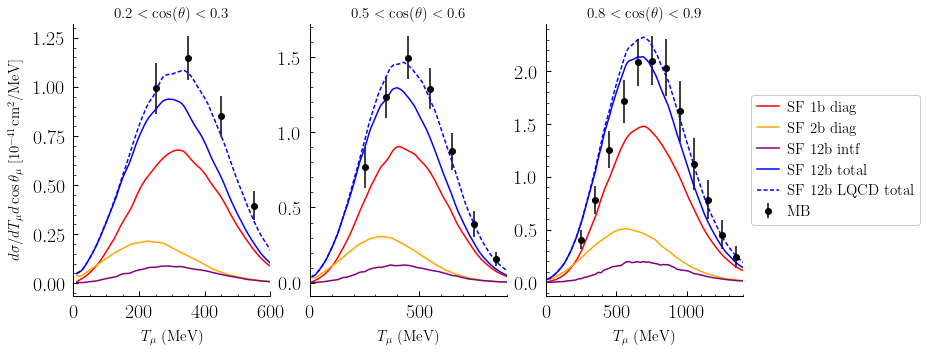

In [3]:
fig4, ax4 = plt.subplots(1,3,figsize=(12, 5))
ax4=ax4.flatten()

#0.8 cos
ax4[2].errorbar(data_df[1]['tmu'],data_df[1]['xsec'],data_df[1]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB')
ax4[2].plot(tmu_interp[2], QE_interp[2], label=r'SF 1b diag', color='red')
ax4[2].plot(tmu_interp[2], MEC_interp[2], label=r'SF 2b diag', color='orange')
#ax4[2].plot(tmu_interp[2], QE_interp_lattice[2], label=r'SF LQCD 1b diag', color='red',linestyle='--')
ax4[2].plot(tmu_interp[2], Intf_interp[2], label=r'SF 12b intf', color='purple')
#ax4[2].plot(tmu_interp[2], Intf_interp_lattice[2], label=r'SF LQCD 12b intf', color='purple',linestyle='--')
ax4[2].plot(tmu_interp[2], Intf_interp[2] + QE_interp[2] +  MEC_interp[2], label=r'SF 12b total', color='blue')
ax4[2].plot(tmu_interp[2], Intf_interp_lattice[2] + QE_interp_lattice[2] +  MEC_interp[2], label=r'SF 12b LQCD total', color='blue',linestyle='--')
ax4[2].set_title(r'$0.8 < \cos(\theta) < 0.9$', fontsize=15)
ax4[2].set_xbound(0,1400)
ax4[2].set_xlabel(r'$T_{\mu}$ (MeV)', fontsize=15)

ax4[1].errorbar(data_df[4]['tmu'],data_df[4]['xsec'],data_df[4]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB')
ax4[1].plot(tmu_interp[1], QE_interp[1], label=r'SF 1b diag', color='red')
ax4[1].plot(tmu_interp[1], MEC_interp[1], label=r'SF 2b diag', color='orange')
#ax4[1].plot(tmu_interp[1], QE_interp_lattice[1], label=r'SF LQCD 1b diag', color='red',linestyle='--')
ax4[1].plot(tmu_interp[1], Intf_interp[1], label=r'SF 12b intf', color='purple')
#ax4[1].plot(tmu_interp[1], Intf_interp_lattice[1], label=r'SF LQCD 12b intf', color='purple',linestyle='--')
ax4[1].plot(tmu_interp[1], Intf_interp[1] + QE_interp[1] +  MEC_interp[1], label=r'SF 12b total', color='blue')
ax4[1].plot(tmu_interp[1], Intf_interp_lattice[1] + QE_interp_lattice[1] +  MEC_interp[1], label=r'SF 12b LQCD total', color='blue',linestyle='--')
ax4[1].set_title(r'$0.5 < \cos(\theta) < 0.6$', fontsize=15)
ax4[1].set_xbound(0,900)
ax4[1].set_xlabel(r'$T_{\mu}$ (MeV)', fontsize=15)

ax4[0].errorbar(data_df[7]['tmu'],data_df[7]['xsec'],data_df[7]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB')
ax4[0].plot(tmu_interp[0], QE_interp[0], label=r'SF 1b diag', color='red')
ax4[0].plot(tmu_interp[0], MEC_interp[0], label=r'SF 2b diag', color='orange')
#ax4[0].plot(tmu_interp[0], QE_interp_lattice[0], label=r'SF LQCD 1b diag', color='red',linestyle='--')
ax4[0].plot(tmu_interp[0], Intf_interp[0], label=r'SF 12b intf', color='purple')
#ax4[0].plot(tmu_interp[0], Intf_interp_lattice[0], label=r'SF LQCD 12b intf', color='purple',linestyle='--')
ax4[0].plot(tmu_interp[0], Intf_interp[0] + QE_interp[0] +  MEC_interp[0], label=r'SF 12b total', color='blue')
ax4[0].plot(tmu_interp[0], Intf_interp_lattice[0] + QE_interp_lattice[0] +  MEC_interp[0], label=r'SF 12b LQCD total', color='blue',linestyle='--')
ax4[0].set_title(r'$0.2 < \cos(\theta) < 0.3$', fontsize=15)
ax4[0].set_xbound(0,600)
ax4[0].set_xlabel(r'$T_{\mu}$ (MeV)', fontsize=15)
ax4[0].set_ylabel(r'$d\sigma /dT_{\mu}d\cos\theta_{\mu} $ $[10^{-41} \rm{cm^{2}/MeV}]$', fontsize=15)


for i in range(0,3):
        ax4[i].spines['right'].set_visible(False)
        ax4[i].spines['top'].set_visible(False)
        ax4[i].get_xaxis().tick_bottom()
        ax4[i].get_yaxis().tick_left()
        


#ax4[5].set_yscale('log')
ax4[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})
#plt.savefig('MB_12b_intf_sep.png',facecolor='white',bbox_inches='tight', dpi=300)

In [5]:
from scipy import integrate
QE_int = [0,0,0]
MEC_int = [0,0,0]
Intf_int = [0,0,0]
for i in range(0,3):
    QE_int[i] = integrate.cumtrapz(QE_df[i]['1b'],QE_df[i]['tmu'])
    MEC_int[i] = integrate.cumtrapz(MEC_df[i]['xsec'],MEC_df[i]['tmu'])
    Intf_int[i] = integrate.cumtrapz(intf_df[i]['2b'],intf_df[i]['tmu'])

In [6]:
thetabin=['0.2 < cos < 0.3', '0.5 < cos < 0.6', '0.8 < cos < 0.9']

for i in range(0,3):
    print('Cos Theta Bin ',thetabin[i],':')
    print('Interferance contribution to integrated xsec = ', 100*Intf_int[i][-1]/(Intf_int[i][-1] + MEC_int[i][-1] + QE_int[i][-1]))
    print('MEC contribution to integrated xsec = ', 100*MEC_int[i][-1]/(Intf_int[i][-1] + MEC_int[i][-1] + QE_int[i][-1]))
    print('QE contribution to integrated xsec = ', 100*QE_int[i][-1]/(Intf_int[i][-1] + MEC_int[i][-1] + QE_int[i][-1]))
    print('\n')

Cos Theta Bin  0.2 < cos < 0.3 :
Interferance contribution to integrated xsec =  8.687997547362075
MEC contribution to integrated xsec =  20.785996902146636
QE contribution to integrated xsec =  70.52600555049129


Cos Theta Bin  0.5 < cos < 0.6 :
Interferance contribution to integrated xsec =  8.619351588221663
MEC contribution to integrated xsec =  22.047164453015906
QE contribution to integrated xsec =  69.33348395876243


Cos Theta Bin  0.8 < cos < 0.9 :
Interferance contribution to integrated xsec =  8.681109292297725
MEC contribution to integrated xsec =  22.73940804948022
QE contribution to integrated xsec =  68.57948265822205




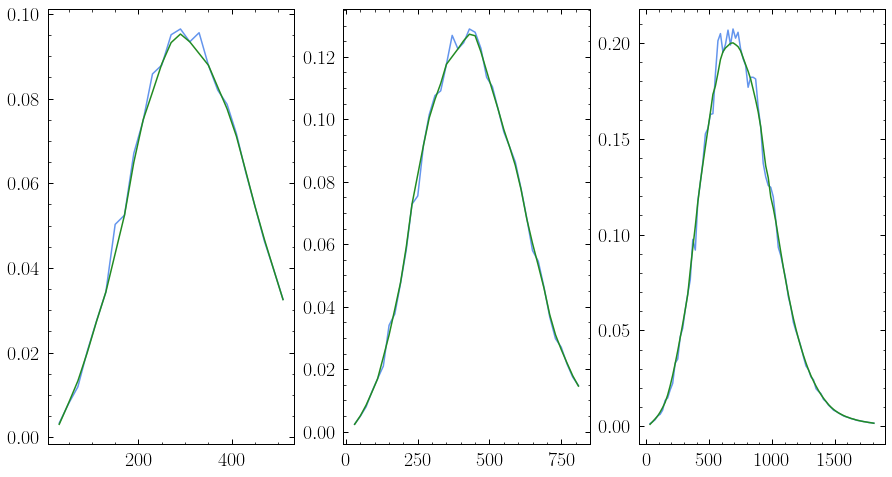

In [41]:

#I have to smooth out some of the intf predictions because the flux folding gave me a very noisy prediction for some reason

#intf_maxbin = [100,145,220]
intf_maxbin = [25,40,90]
intf_fracparam = [.20,.12,.09]
intf_tmu_interp= [0,0,0]
intf_interp = [0,0,0]

intf_lattice_maxbin = [25,40,90]
intf_lattice_fracparam = [.20,.12,.09]
intf_tmu_lattice_interp= [0,0,0]

intf_lattice_interp = [0,0,0]

for i,df in enumerate(intf_lattice_df):
    interp = sm.nonparametric.lowess(df['2b'][:intf_lattice_maxbin[i]], df['tmu'][:intf_lattice_maxbin[i]],frac = intf_lattice_fracparam[i])
    intf_tmu_lattice_interp[i] = interp[:,0][:intf_lattice_maxbin[i]]
    intf_lattice_interp[i] = interp[:,1][:intf_lattice_maxbin[i]]

for i,df in enumerate(intf_df):
    interp = sm.nonparametric.lowess(df['2b'][:intf_maxbin[i]], df['tmu'][:intf_maxbin[i]],frac = intf_fracparam[i])
    intf_tmu_interp[i] = interp[:,0][:intf_maxbin[i]]
    intf_interp[i] = interp[:,1][:intf_maxbin[i]]
    
    
fig,ax = plt.subplots(1,3,figsize=(15,8))

for i in range(0,3):
    ax[i].plot(intf_lattice_df[i]['tmu'][:intf_lattice_maxbin[i]], intf_lattice_df[i]['2b'][:intf_lattice_maxbin[i]])
    ax[i].plot(intf_tmu_lattice_interp[i], intf_lattice_interp[i])

<ipython-input-9-488b855d4a92>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax4[2].errorbar(data_df[1]['tmu'],data_df[1]['xsec'],data_df[1]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB CCQE')
<ipython-input-9-488b855d4a92>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax4[1].errorbar(data_df[4]['tmu'],data_df[4]['xsec'],data_df[4]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB CCQE')
<ipython-input-9-488b855d4a92>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax4[0].errorbar(data_df[7]['tmu'],data_df[7]['xsec'],data_df[7]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB CCQE')


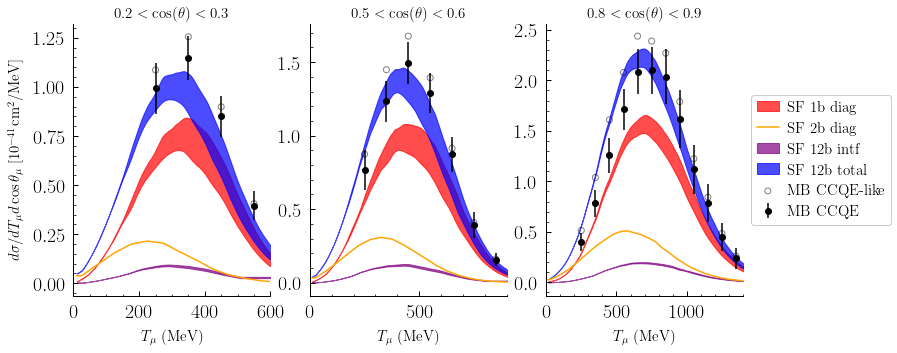

In [9]:
fig4, ax4 = plt.subplots(1,3,figsize=(12, 5))
ax4=ax4.flatten()

#0.8 cos

ax4[2].fill_between(tmu_interp[2], QE_interp[2],QE_interp_lattice[2], label=r'SF 1b diag', color='red',alpha=0.7)
ax4[2].plot(tmu_interp[2], MEC_interp[2], label=r'SF 2b diag', color='orange')
ax4[2].fill_between(tmu_interp[2], Intf_interp[2],Intf_interp_lattice[2], label=r'SF 12b intf', color='purple',alpha=0.7)
ax4[2].fill_between(tmu_interp[2], Intf_interp[2] + QE_interp[2] + MEC_interp[2],Intf_interp_lattice[2] + QE_interp_lattice[2] + MEC_interp[2],label = r'SF 12b total', color='blue', alpha = 0.7 )
ax4[2].errorbar(data_df[1]['tmu'],data_df[1]['xsec'],data_df[1]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB CCQE')
ax4[2].scatter(data_df[1]['tmu'],data_df[1]['xsec'] + bkgd_df[2]['xsec'],facecolors='none', edgecolors='black',label='MB CCQE-like',alpha=0.5) 
ax4[2].set_title(r'$0.8 < \cos(\theta) < 0.9$', fontsize=15)
ax4[2].set_xbound(0,1400)
ax4[2].set_xlabel(r'$T_{\mu}$ (MeV)', fontsize=15)


ax4[1].fill_between(tmu_interp[1], QE_interp[1],QE_interp_lattice[1], label=r'SF 1b diag', color='red',alpha=0.7)
ax4[1].plot(tmu_interp[1], MEC_interp[1], label=r'SF 2b diag', color='orange')
ax4[1].fill_between(tmu_interp[1], Intf_interp[1],Intf_interp_lattice[1], label=r'SF 12b intf', color='purple',alpha=0.7)
ax4[1].fill_between(tmu_interp[1], Intf_interp[1] + QE_interp[1] + MEC_interp[1],Intf_interp_lattice[1] + QE_interp_lattice[1] + MEC_interp[1],label = r'SF 12b total', color='blue', alpha = 0.7 )
ax4[1].errorbar(data_df[4]['tmu'],data_df[4]['xsec'],data_df[4]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB CCQE')
ax4[1].scatter(data_df[4]['tmu'],data_df[4]['xsec'] + bkgd_df[1]['xsec'],facecolors='none', edgecolors='black',label='MB CCQE-like',alpha=0.5) 
ax4[1].set_title(r'$0.5 < \cos(\theta) < 0.6$', fontsize=15)
ax4[1].set_xbound(0,900)
ax4[1].set_xlabel(r'$T_{\mu}$ (MeV)', fontsize=15)


ax4[0].fill_between(tmu_interp[0], QE_interp[0],QE_interp_lattice[0], label=r'SF 1b diag', color='red',alpha=0.7)
ax4[0].plot(tmu_interp[0], MEC_interp[0], label=r'SF 2b diag', color='orange')
ax4[0].fill_between(tmu_interp[0], Intf_interp[0],Intf_interp_lattice[0], label=r'SF 12b intf', color='purple',alpha=0.7)
ax4[0].fill_between(tmu_interp[0], Intf_interp[0] + QE_interp[0] + MEC_interp[0],Intf_interp_lattice[0] + QE_interp_lattice[0] + MEC_interp[0],label = r'SF 12b total', color='blue', alpha = 0.7 )
ax4[0].errorbar(data_df[7]['tmu'],data_df[7]['xsec'],data_df[7]['xsec_err'],color='black',fmt="ko",ecolor='black',label='MB CCQE')
ax4[0].scatter(data_df[7]['tmu'],data_df[7]['xsec'] + bkgd_df[0]['xsec'],facecolors='none', edgecolors='black',label='MB CCQE-like',alpha=0.5) 
ax4[0].set_title(r'$0.2 < \cos(\theta) < 0.3$', fontsize=15)
ax4[0].set_xbound(0,600)
ax4[0].set_xlabel(r'$T_{\mu}$ (MeV)', fontsize=15)
ax4[0].set_ylabel(r'$d\sigma /dT_{\mu}d\cos\theta_{\mu} $ $[10^{-41} \rm{cm^{2}/MeV}]$', fontsize=15)


for i in range(0,3):
        ax4[i].spines['right'].set_visible(False)
        ax4[i].spines['top'].set_visible(False)
        ax4[i].get_xaxis().tick_bottom()
        ax4[i].get_yaxis().tick_left()

#ax4[5].set_yscale('log')
ax4[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})
plt.savefig('MB_12b_intf_sep_band.png',facecolor='white',bbox_inches='tight', dpi=300)